In [1]:
import gym, importlib, sys, warnings, IPython
import tensorflow as tf
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%autosave 240
warnings.filterwarnings("ignore")
print(tf.__version__)

Autosaving every 240 seconds
1.13.1


In [2]:
sys.path.append('../../embodied_arch/')
import embodied as emg
from embodied_misc import ActionPolicyNetwork, SensoriumNetworkTemplate
importlib.reload(emg)

<module 'embodied' from '../../embodied_arch/embodied.py'>

## Cartpole Benchmark Setup

In [3]:
actor = lambda s: ActionPolicyNetwork(s, hSeq=(10,), gamma_reg=1e-1)
sensor = lambda st, out_dim: SensoriumNetworkTemplate(st, hSeq=(32,), out_dim=out_dim, gamma_reg=1e-1)

In [4]:
tf.reset_default_graph()
importlib.reload(emg)
env = gym.make('CartPole-v0')
cprf = emg.EmbodiedAgentRF(name="cp-emb", env_=env,
                           space_size = (4,1),latentDim=8,
                           alpha=0.52, actorNN=actor, sensorium=sensor
                          ) 
# cprf = emg.EmbodiedAgentRFBaselined(name="cp-emb-b", env_=env,
#                            space_size = (4,1),latentDim=8,
#                            alpha_p=0.52, alpha_v=0.52, actorNN=actor, sensorium=sensor )
print(cprf, cprf.s_size, cprf.a_size)

Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Colocations handled automatically by placer.
<embodied.EmbodiedAgentRF object at 0x7fbd41b93e48> 4 1


In [5]:
saver = tf.train.Saver(max_to_keep=1)  #n_epochs = 1000
sess = tf.InteractiveSession() 
cprf.init_graph(sess)

num_episodes = 100
n_epochs = 3501

Tensorboard logs in:  ./log/train_cp-emb


In [6]:
## Verify step + play set up
state = cprf.env.reset()
print(state, cprf.act(state, sess))
# cprf.env.step(cprf.act(state, sess))

cprf.play(sess)
len(cprf.episode_buffer)

[ 0.04828874 -0.0078043  -0.02916095 -0.0079173 ] 0


21

## Baseline

In [7]:
print('Baselining untrained pnet...')
uplen0 = []
for k in range(num_episodes):
    cprf.play(sess)
    uplen0.append(cprf.last_total_return) # uplen0.append(len(cprf.episode_buffer))
    if k%20 == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
base_perf = np.mean(uplen0)
print("\nCartpole stays up for an average of {} steps".format(base_perf))

Baselining untrained pnet...
Episode 80/100
Cartpole stays up for an average of 23.83 steps


## Train

In [8]:
# Train pnet on cartpole episodes
print('Training...')
saver = tf.train.Saver(max_to_keep=1)
cprf.work(sess, saver, num_epochs=n_epochs)

Training...
Starting agent cp-emb
Epoch no.: 0/3501
Step 0: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [11.0, -0.6977896, 0.69309616] )
Saved Model
Epoch no.: 500/3501
Step 500: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [28.0, -0.7097859, 0.65777487] )
Instructions for updating:
Use standard file APIs to delete files with this prefix.
Saved Model
Epoch no.: 1000/3501
Step 1000: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [78.0, -0.54740566, 0.6006673] )
Saved Model
Epoch no.: 1500/3501
Step 1500: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [74.0, -0.6031761, 0.5503912] )
Saved Model
Epoch no.: 2000/3501
Step 2000: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [166.0, -0.49612486, 0.503149] )
Saved Model
Epoch no.: 2500/3501
Step 2500: Stats(['Perf/Recent Reward', 'Losses/Policy LL', 'Losses/Entropy']): ( [129.0, -0.39513785, 0.4894547] )
Saved Model
Ep

## Test

In [9]:
# Test pnet!
print('Testing...')
uplen = []
for k in range(num_episodes):
    cprf.play(sess)
    uplen.append(cprf.last_total_return) # uplen.append(len(cprf.episode_buffer))
    if k%20 == 0: print("\rEpisode {}/{}".format(k, num_episodes),end="")
trained_perf = np.mean(uplen)
print("\nCartpole stays up for an average of {} steps compared to baseline {} steps".format(trained_perf, base_perf) )

Testing...
Episode 80/100
Cartpole stays up for an average of 147.64 steps compared to baseline 23.83 steps


## Evaluate

Text(0.5, 1.0, 'Trained Episode Lengths')

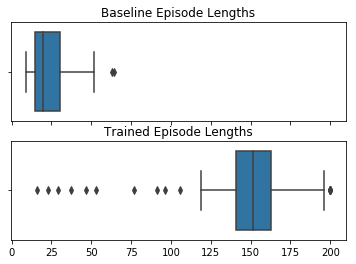

In [10]:
fig, axs = plt.subplots(2, 1, sharex=True)
sns.boxplot(uplen0, ax = axs[0])
axs[0].set_title('Baseline Episode Lengths')
sns.boxplot(uplen, ax = axs[1])
axs[1].set_title('Trained Episode Lengths')

In [11]:
buf = []
last_total_return, d, s = 0, False, cprf.env.reset() 
while (len(buf) < 1000) and not d:
    a_t = cprf.act(s, sess) 
    s1, r, d, *rest = cprf.env.step(a_t)
    cprf.env.render()
    buf.append([s, a_t, float(r), s1])
    last_total_return += float(r)
    s = s1
    print("\r\tEpisode Length", len(buf), end="")

	Episode Length 136

In [12]:
sess.close()